In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
import copy
from tqdm.notebook import tqdm
from numba import jit
from scipy import stats
import networkx as nx
import random
import re
from numba import njit

#plt.style.use('seaborn-deep')
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 24
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8

# Taken from https://github.com/giotto-ai/giotto-tda/blob/master/examples/classifying_shapes.ipynb

In [2]:
from generate_datasets import make_point_clouds
num_points = 20
num_samples = 10
point_clouds_basic, labels_basic = make_point_clouds(n_samples_per_shape=num_samples, n_points=num_points, noise=0.5)
point_clouds_basic.shape, labels_basic.shape

((30, 400, 3), (30,))

In [3]:
from gtda.plotting import plot_point_cloud

plot_point_cloud(point_clouds_basic[0])

In [4]:
plot_point_cloud(point_clouds_basic[10])

In [5]:
plot_point_cloud(point_clouds_basic[-1])

# RJ some comments:
We need to have the same shape of `all_diagrams` as in the original code so we can use it in the next pipeline.

```
diagrams_basic.shape = (n_examples, X, n_k_values)

where k_values = [0, 1, 2] 
```

X is a some values extracted from PH (but the size does not matter, I think).

Once we will have `all_diagrams` in a right format we could use it in the function:

```
from gtda.diagrams import PersistenceEntropy

persistence_entropy = PersistenceEntropy()

# calculate topological feature matrix
X_basic = persistence_entropy.fit_transform(diagrams_basic)

# expect shape - (n_point_clouds, n_homology_dims)
X_basic.shape

```

And later we can follow what they did.



In [6]:
from pynndescent import NNDescent
import math

def euclidean_distance_3d(p, q):
     return math.sqrt((p[0] - q[0])**2 + (p[1] - q[1])**2 + (p[2] - q[2])**2)

# function to convert point cloud into graph
def convert_pointcloud_to_graph(point_cloud, graph_type, r=None, k=None):
    if graph_type == 'knn':
        if k is None:
            raise ValueError("Parameter 'k' must be provided for 'knn' graph type.")
        # graph construction using knn

        # Compute kNN using NNDescent
        # indices: array where each row contains the indices of the k-nearest neighbors for each point.
        # I put k+1 because the algorithm counts the same node as the nearest
        knnData = NNDescent(point_cloud, metric="euclidean", n_neighbors=k+1, verbose=False)
        indices, distances = knnData.neighbor_graph

        # Create graph
        G = nx.Graph()

        for i in range(len(point_clouds_basic[0])):
            G.add_node(i, pos=tuple(point_cloud[i]))

        # Add edges based on kNN
        for i in range(len(point_cloud)):
            for j in indices[i]:  
                if i!=j: # this is to exclude self loops
                    G.add_edge(i, j)
        return(G)
        
    elif graph_type == 'rgg':
        if r is None:
            raise ValueError("Parameter 'r' must be provided for 'rgg' graph type.")
        # graph construction using rgg

        G = nx.Graph()

        for i in range(len(point_clouds_basic[0])):
            G.add_node(i, pos=tuple(point_cloud[i]))

        # Add edges based on random geometric graph
        for i in range(len(point_cloud)):
            for j in range(len(point_cloud)):  
                if i!=j:
                    if euclidean_distance_3d(point_cloud[i],point_cloud[j]) < r:
                        G.add_edge(i, j)
        return(G)
    
    else:
        raise ValueError("graph_type must be 'rgg' or 'knn'.")


In [7]:
# The function that takes a graph G and computes persistence diagrams with a given edge or node filtration is already created
# it's this one: calculate_persistence_diagram(G, filtration, k_homology)

from filtrations import density_sum_cycles, ollivier_ricci_curvature, edge_betweenness_centrality, vietoris_rips, laplacian_eigenvalues, degrees
from diagrams import calculate_persistence_diagram

filename = "graphs/point_cloud0_knn_4_degree_khomo_1.edgelist"
G = nx.read_edgelist(filename, nodetype=int)  
persistence_diagram_OR = calculate_persistence_diagram(G, ollivier_ricci_curvature, 1)
persistence_diagram_degrees = calculate_persistence_diagram(G, degrees, 1, True) # Use True for node-based filtrations
# density_sum_cycles requires fortran
# persistence_diagram = calculate_persistence_diagram(G, density_sum_cycles, 1)
persistence_diagram_BC = calculate_persistence_diagram(G, edge_betweenness_centrality, 1)
persistence_diagram_laplacian = calculate_persistence_diagram(G, laplacian_eigenvalues, 1, True)
# I had to modify the function generate_shortest_path_distance_matrix in distances.py to ensure node labels are sequential from 0 to len(G)-1
persistence_diagram_VR = calculate_persistence_diagram(G, vietoris_rips, 1, True)


In [8]:
# function that processes all point clouds
import csv

def get_filtration_name(filtration_type):
    if filtration_type == degrees:
        return 'degree'
    if filtration_type == ollivier_ricci_curvature:
        return 'ORC'
    if filtration_type == edge_betweenness_centrality:
        return 'EBC'
    if filtration_type == vietoris_rips:
        return 'VR'
    if filtration_type == laplacian_eigenvalues:
        return 'laplacian'

# k_values = [4, 5, 6, 7, 8, 9, 10, 20, 30]
# r_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
def get_persistent_diagrams_from_graphs(point_cloud, num_cloud, graph_type, filtration_type, k_homology, k_values = [4, 5, 6, 7], r_values = [0.1, 0.3]):
    diagrams = []
    filtration_name = get_filtration_name(filtration_type)
    if graph_type == 'knn':
        for k in k_values:
            G = convert_pointcloud_to_graph(point_cloud, 'knn', None, k)
            
            # Save the graph to an edgelist file
            output_filename = f"graphs/point_cloud{num_cloud}_knn_{k}_{filtration_name}_khomo_{k_homology}.edgelist"
            nx.write_edgelist(G, output_filename, data=False) 
            print(f"Graph saved to {output_filename}")
            if filtration_type in [degrees, vietoris_rips, laplacian_eigenvalues]:
                persistence_diagram = calculate_persistence_diagram(G, filtration_type, k_homology, True)
            else:
                persistence_diagram = calculate_persistence_diagram(G, filtration_type, k_homology)
            diagrams.append(persistence_diagram)

            output_filename_diagram = f"diagrams/point_cloud{num_cloud}_knn_{k}_{filtration_name}_khomo_{k_homology}.csv"
            with open(output_filename_diagram, "w", newline="") as f:
                writer = csv.writer(f)
                writer.writerow(["birth", "death", "k dimension"]) 
                writer.writerows(persistence_diagram)  
            print(f"Diagram saved to {output_filename_diagram}")
        return diagrams
    
    elif graph_type == 'rgg':
        for r in r_values:
            G = convert_pointcloud_to_graph(point_cloud, 'rgg', r, None)
            
            output_filename = f"graphs/point_cloud{num_cloud}_rgg_{r}_{filtration_name}_khomo_{k_homology}.edgelist"
            nx.write_edgelist(G, output_filename, data=False) 
            print(f"Graph saved to {output_filename}")

            if filtration_type in [degrees, vietoris_rips, laplacian_eigenvalues]:
                persistence_diagram = calculate_persistence_diagram(G, filtration_type, k_homology, True)
            else:
                persistence_diagram = calculate_persistence_diagram(G, filtration_type, k_homology)
            diagrams.append(persistence_diagram)

            output_filename_diagram = f"diagrams/point_cloud{num_cloud}_rgg_{r}_{filtration_name}_khomo_{k_homology}.csv"
            with open(output_filename_diagram, "w", newline="") as f:
                writer = csv.writer(f)
                writer.writerow(["birth", "death", "k dimension"]) 
                writer.writerows(persistence_diagram)  
            print(f"Diagram saved to {output_filename_diagram}")
        return diagrams

    else:
        raise ValueError("graph_type must be 'rgg' or 'knn'.")



def get_all_diagrams(point_clouds_basic, filtration_type, graph_type, k_homology_max):
    all_diagrams = []  # List to store diagrams for all point clouds

    for num_cloud in range(len(point_clouds_basic)):
        point_cloud = point_clouds_basic[num_cloud]  
        
        # TODO: this code needs just to return one diagram for given set of params:
        #   - graph_type and avg_degree(k_value) or radius
        diagrams = get_persistent_diagrams_from_graphs(point_cloud, num_cloud, 'knn', 
                                                       filtration_type, k_homology_max, k_values=[5])[0]     
        
        all_diagrams.append(diagrams)
        
    all_diagrams = np.array(all_diagrams)
    all_diagrams.reshape(num_samples, -1, len(k_homology_list))

    return all_diagrams


k_homology_max = 2 # it will compute values from 0 to k_homology_max
filtration_type = degrees
graph_type = 'knn'
all_diagrams = get_all_diagrams(point_clouds_basic, filtration_type, graph_type, k_homology_max)

"""
# Add density_sum_cycles
filtrations_list = [degrees, ollivier_ricci_curvature, edge_betweenness_centrality, vietoris_rips, laplacian_eigenvalues]
graph_type_list = ['knn', 'rgg']
# k_homology_list = [0, 1, 2, 3, 4]
# for filtration_type in filtrations_list:
    # for graph_type in graph_type_list: 
"""

Graph saved to graphs/point_cloud0_knn_5_degree_khomo_2.edgelist
Diagram saved to diagrams/point_cloud0_knn_5_degree_khomo_2.csv
Graph saved to graphs/point_cloud1_knn_5_degree_khomo_2.edgelist
Diagram saved to diagrams/point_cloud1_knn_5_degree_khomo_2.csv
Graph saved to graphs/point_cloud2_knn_5_degree_khomo_2.edgelist
Diagram saved to diagrams/point_cloud2_knn_5_degree_khomo_2.csv
Graph saved to graphs/point_cloud3_knn_5_degree_khomo_2.edgelist
Diagram saved to diagrams/point_cloud3_knn_5_degree_khomo_2.csv
Graph saved to graphs/point_cloud4_knn_5_degree_khomo_2.edgelist
Diagram saved to diagrams/point_cloud4_knn_5_degree_khomo_2.csv
Graph saved to graphs/point_cloud5_knn_5_degree_khomo_2.edgelist
Diagram saved to diagrams/point_cloud5_knn_5_degree_khomo_2.csv
Graph saved to graphs/point_cloud6_knn_5_degree_khomo_2.edgelist
Diagram saved to diagrams/point_cloud6_knn_5_degree_khomo_2.csv
Graph saved to graphs/point_cloud7_knn_5_degree_khomo_2.edgelist
Diagram saved to diagrams/point_

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (30,) + inhomogeneous part.

In [9]:
p1 = point_clouds_basic[-1]
plot_point_cloud(p1)

In [10]:
g1 = convert_pointcloud_to_graph(p1, 'knn', k=10)
print(g1)

Graph with 400 nodes and 2282 edges


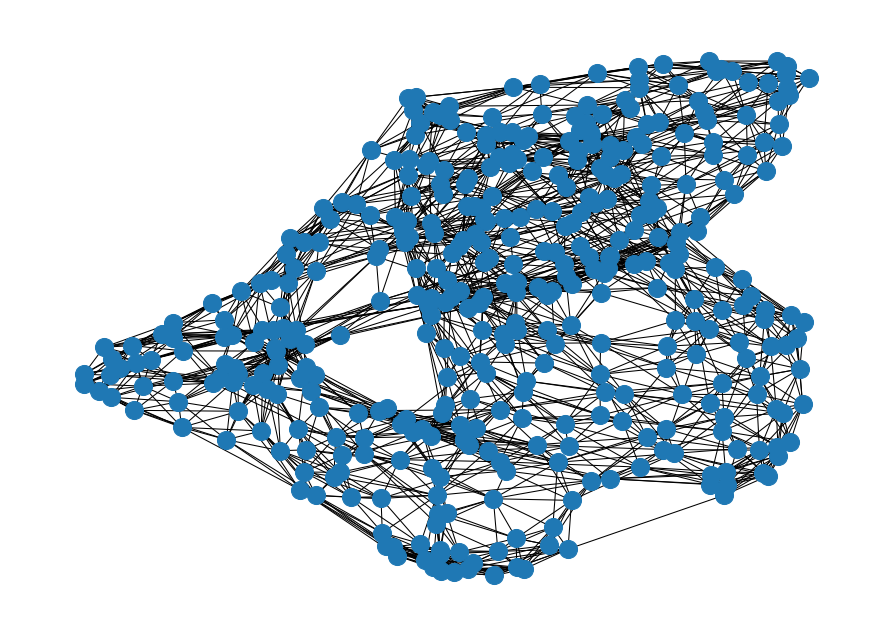

In [11]:
nx.draw(g1)

In [12]:
from gtda.plotting import plot_diagram

d1 = calculate_persistence_diagram(g1, edge_betweenness_centrality, k=3)

plot_diagram(d1)

In [13]:
plot_diagram(all_diagrams[0])

NameError: name 'all_diagrams' is not defined

In [16]:
def compute_diagrams_from_point_clouds(point_clouds):
    all_diagrams = []
    for p in tqdm(point_clouds):
        g = convert_pointcloud_to_graph(p, 'knn', k=5)
        d = calculate_persistence_diagram(g, edge_betweenness_centrality, k=2)
        all_diagrams.append(d)
#     return np.array(all_diagrams)
    return all_diagrams

tmp_diagrams = compute_diagrams_from_point_clouds(point_clouds_basic)
# tmp_diagrams.shape

  0%|          | 0/30 [00:00<?, ?it/s]

In [17]:
[t.shape for t in tmp_diagrams] # it appears that the number of features differ across point clouds...

[(904, 3),
 (891, 3),
 (853, 3),
 (842, 3),
 (886, 3),
 (891, 3),
 (908, 3),
 (882, 3),
 (879, 3),
 (882, 3),
 (860, 3),
 (817, 3),
 (829, 3),
 (863, 3),
 (850, 3),
 (823, 3),
 (858, 3),
 (838, 3),
 (854, 3),
 (849, 3),
 (734, 3),
 (750, 3),
 (754, 3),
 (765, 3),
 (730, 3),
 (744, 3),
 (764, 3),
 (752, 3),
 (757, 3),
 (752, 3)]

In [18]:
def cap_inf_values(diagram, cap=None):
    """
    Replace infinite death times in a persistence diagram with a finite cap.
    
    Parameters
    ----------
    diagram : numpy.ndarray, shape (n_points, 3)
        Persistence diagram where the first column is birth, the second is death,
        and the third column represents the homology dimension.
    cap : float, optional
        The value to replace infinity with. If None, the cap is set to the maximum
        finite death time found in the diagram.
    
    Returns
    -------
    capped_diagram : numpy.ndarray
        Persistence diagram with infinite death times replaced by the cap.
    """
    # Make a copy so as not to modify the original diagram
    capped_diagram = diagram.copy()
    
    # Find finite death values in the diagram (assume death times are in column 1)
    finite_deaths = capped_diagram[np.isfinite(capped_diagram[:, 1]), 1]
    if cap is None:
        if finite_deaths.size == 0:
            raise ValueError("No finite death values found to determine a cap.")
        cap = 10.0 # some large value
    
    # Replace inf values in the death column with the cap
    capped_diagram[np.isinf(capped_diagram[:, 1]), 1] = cap
    return capped_diagram

In [19]:
capped_diagrams = [cap_inf_values(d) for d in tmp_diagrams]
len(capped_diagrams)

30

In [20]:
[t.shape for t in capped_diagrams] # it appears that the number of features differ across point clouds...

[(904, 3),
 (891, 3),
 (853, 3),
 (842, 3),
 (886, 3),
 (891, 3),
 (908, 3),
 (882, 3),
 (879, 3),
 (882, 3),
 (860, 3),
 (817, 3),
 (829, 3),
 (863, 3),
 (850, 3),
 (823, 3),
 (858, 3),
 (838, 3),
 (854, 3),
 (849, 3),
 (734, 3),
 (750, 3),
 (754, 3),
 (765, 3),
 (730, 3),
 (744, 3),
 (764, 3),
 (752, 3),
 (757, 3),
 (752, 3)]

In [21]:
capped_diagrams[0]

array([[-1.00000000e+00,  1.00000000e+01,  0.00000000e+00],
       [-1.00000000e+00,  1.26075428e-01,  0.00000000e+00],
       [-1.00000000e+00,  6.83893786e-02,  0.00000000e+00],
       ...,
       [ 1.05022461e-04,  1.00000000e+01,  2.00000000e+00],
       [ 1.61149368e-04,  1.00000000e+01,  2.00000000e+00],
       [ 2.86232623e-04,  1.00000000e+01,  2.00000000e+00]])

In [22]:
from gtda.diagrams import PersistenceImage

pi = PersistenceImage()

persistence_images = pi.fit_transform(capped_diagrams)

print("Transformed diagrams shape:", persistence_images.shape)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (30,) + inhomogeneous part.

In [27]:
tmp_diagrams[0]

array([[-1.00000000e+00,             inf,  0.00000000e+00],
       [-1.00000000e+00,  1.26075428e-01,  0.00000000e+00],
       [-1.00000000e+00,  6.83893786e-02,  0.00000000e+00],
       ...,
       [ 1.05022461e-04,             inf,  2.00000000e+00],
       [ 1.61149368e-04,             inf,  2.00000000e+00],
       [ 2.86232623e-04,             inf,  2.00000000e+00]])

In [217]:
# for i, cloud_diagrams in enumerate(all_diagrams):
#     print(f"Point cloud {i + 1}:")
#     for k, diagrams in enumerate(cloud_diagrams):
#         print(f"  k={k_homology_list[k]}: {len(diagrams)} diagrams")  

# print(all_diagrams)
# all_diagrams.shape

In [24]:
%%time

from gtda.homology import VietorisRipsPersistence

# Track connected components, loops, and voids
homology_dimensions = [0, 1, 2]

# Collapse edges to speed up H2 persistence calculation!
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)

diagrams_basic = persistence.fit_transform(point_clouds_basic)

CPU times: total: 141 ms
Wall time: 19.8 s


In [160]:
diagrams_basic[0].shape

(590, 3)

In [161]:
point_clouds_basic.shape

(30, 400, 3)

In [162]:
diagrams_basic.shape

(30, 590, 3)

In [163]:
all_diagrams.shape

(30,)

In [218]:
plot_diagram(diagrams_basic[0])

In [223]:
# print(all_diagrams)
# final_diagrams = []

# for x in all_diagrams:
#     for y in x:
#         tmp = np.concatenate(y)
#         final_diagrams.append(tmp)

# final_diagrams = np.array(final_diagrams)
# final_diagrams.shape

In [230]:
plot_diagram(tmp_diagrams[-1])

In [227]:
plot_diagram(capped_diagrams[-1])

In [28]:
from gtda.diagrams import PersistenceEntropy,BettiCurve, NumberOfPoints

persistence_entropy = PersistenceEntropy()

# calculate topological feature matrix
# X_basic = persistence_entropy.fit_transform(diagrams_basic)
X_basic = persistence_entropy.fit_transform(capped_diagrams)

# expect shape - (n_point_clouds, n_homology_dims)
X_basic.shape

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (30,) + inhomogeneous part.

In [208]:
X_basic

array([[ 8.60564276,  6.10613106, 11.1296611 ],
       [ 8.60564276,  6.10613106, 11.1296611 ],
       [ 8.60564276,  6.10613106, 11.1296611 ],
       [ 8.60564276,  6.10613106, 11.1296611 ],
       [ 8.60564276,  6.10613106, 11.1296611 ],
       [ 8.60564276,  6.10613106, 11.1296611 ],
       [ 8.60564276,  6.10613106, 11.1296611 ],
       [ 8.60564276,  6.10613106, 11.1296611 ],
       [ 8.60564276,  6.10613106, 11.1296611 ],
       [ 8.60564276,  6.10613106, 11.1296611 ],
       [ 8.60564276,  6.10613106, 11.1296611 ],
       [ 8.60564276,  6.10613106, 11.1296611 ],
       [ 8.60564276,  6.10613106, 11.1296611 ],
       [ 8.60564276,  6.10613106, 11.1296611 ],
       [ 8.60564276,  6.10613106, 11.1296611 ],
       [ 8.60564276,  6.10613106, 11.1296611 ],
       [ 8.60564276,  6.10613106, 11.1296611 ],
       [ 8.60564276,  6.10613106, 11.1296611 ],
       [ 8.60564276,  6.10613106, 11.1296611 ],
       [ 8.60564276,  6.10613106, 11.1296611 ],
       [ 8.60564276,  6.10613106, 11.129

In [207]:
plot_point_cloud(X_basic)

In [184]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(oob_score=True)
rf.fit(X_basic, labels_basic)

print(f"OOB score: {rf.oob_score_:.3f}")

OOB score: 0.733


In [153]:
from gtda.pipeline import Pipeline

steps = [
    ("persistence", VietorisRipsPersistence(metric="euclidean", homology_dimensions=homology_dimensions, n_jobs=6)),
    ("entropy", PersistenceEntropy()),
    ("model", RandomForestClassifier(oob_score=True)),
]

pipeline = Pipeline(steps)

In [154]:
pipeline.fit(point_clouds_basic, labels_basic)

Pipeline(steps=[('persistence',
                 VietorisRipsPersistence(homology_dimensions=[0, 1, 2],
                                         n_jobs=6)),
                ('entropy', PersistenceEntropy()),
                ('model', RandomForestClassifier(oob_score=True))])

In [155]:
pipeline["model"].oob_score_

1.0

---
---

In [16]:
from openml.datasets.functions import get_dataset

df = get_dataset('shapes').get_data(dataset_format='dataframe')[0]
df.head()

,x,y,z,target
0,0.341007,0.318606,0.096725,human_arms_out9
1,0.329226,0.421601,0.056749,human_arms_out9
2,0.446869,0.648674,0.124090,human_arms_out9
3,0.314729,0.217860,0.070847,human_arms_out9
4,0.426678,0.919195,0.047609,human_arms_out9


In [17]:
import openml

In [18]:
plot_point_cloud(df.query('target == "biplane0"')[["x", "y", "z"]].values)

In [19]:
import numpy as np

point_clouds = np.asarray(
    [
        df.query("target == @shape")[["x", "y", "z"]].values
        for shape in df["target"].unique()
    ]
)
point_clouds.shape

(40, 400, 3)

In [20]:
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)
persistence_diagrams = persistence.fit_transform(point_clouds)

In [21]:
# Index - (human_arms_out, 0), (vase, 10), (dining_chair, 20), (biplane, 30)
index = 30
plot_diagram(persistence_diagrams[index])

In [22]:
persistence_entropy = PersistenceEntropy(normalize=True)
# Calculate topological feature matrix
X = persistence_entropy.fit_transform(persistence_diagrams)
# Visualise feature matrix
plot_point_cloud(X)

In [23]:
labels = np.zeros(40)
labels[10:20] = 1
labels[20:30] = 2
labels[30:] = 3

rf = RandomForestClassifier(oob_score=True, random_state=42)
rf.fit(X, labels)
rf.oob_score_

0.6